# A Tour of LoRA

Han Zhang, 2nd June, 2023.

In this notebook, we will explore the finetuning using LoRA. We will implement a `LoRAModel` class to finetune an MLP on `MNIST` dataset.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.datasets as datasets

from tqdm import tqdm
from IPython.display import clear_output

In [2]:
def build_layer(in_channels: int, channels: int, dropout: float):
    return nn.Sequential(
        nn.Linear(in_channels, channels, bias=False),
        nn.ReLU(),
        nn.Dropout(dropout)
    )

class MultilayerPerceptronClassifier(nn.Module):
    def __init__(self,
                 num_classes: int,
                 in_channels: int,
                 channels: int,
                 num_layers: int = 1,
                 dropout: float = 0.05):
        nn.Module.__init__(self)

        assert num_layers > 0, num_layers

        layers = [build_layer(in_channels, channels, dropout)]
        for _ in range(1, num_layers):
            layers.append(build_layer(channels, channels, dropout))
        self.layers = nn.ModuleList(layers)
        self.fc = nn.Linear(channels, num_classes, bias=False)

    def forward(self, x: torch.Tensor):
        for layer in self.layers:
            x = layer(x)
        logits = self.fc(x)
        prob = torch.softmax(logits, dim=-1)
        return prob


In [3]:
in_channels = 28 * 28
train_dataset = datasets.MNIST(root='./data', train=True, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, download=True)

train_feature = (train_dataset.data / 255.).view(-1, in_channels).float() - 0.5
test_feature = (test_dataset.data / 255.).view(-1, in_channels).float() - 0.5
train_labels = train_dataset.targets
test_labels = test_dataset.targets

clear_output()

Build the full training data and finetune data. We will classify images of `[0, 1, 2, 3, 4, 5]` for full training. Then we will finetune the model on all 10 classes.

In [4]:
full_train_classes = [0, 1, 2, 3, 4, 5]
full_train_mask = (train_labels <= 5) & (torch.rand(len(train_labels)) > 0.2)
full_test_mask = (test_labels <= 5) & (torch.rand(len(test_labels)) > 0.2)

X_train_1 = train_feature[full_train_mask]
X_train_2 = train_feature[~full_train_mask]
y_train_1 = train_labels[full_train_mask]
y_train_2 = train_labels[~full_train_mask]

X_test_1 = test_feature[full_test_mask]
X_test_2 = test_feature[~full_test_mask]
y_test_1 = test_labels[full_test_mask]
y_test_2 = test_labels[~full_test_mask]

Now we first train the full model.

In [5]:
def get_clean_model():
    return MultilayerPerceptronClassifier(10, 28*28, 128, 2)

In [6]:
device = 'cuda:0'
epochs = 1000
model = get_clean_model()

model = model.to(device)
X_train = X_train_1.to(device)
y_train = y_train_1.to(device)
X_test = X_test_1.to(device)
y_test = y_test_1.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())

train_losses, eval_losses, eval_acc = [], [], []

for epoch in tqdm(range(epochs), desc='Full training'):
    model.train()
    optimizer.zero_grad()
    pred = model(X_train)
    loss = criterion(pred, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    pred = model(X_test)
    loss = criterion(pred, y_test)
    eval_losses.append(loss.item())
    acc = (pred.argmax(-1) == y_test).sum() / len(pred)
    eval_acc.append(acc.item())

Full training: 100%|██████████| 1000/1000 [00:03<00:00, 317.58it/s]


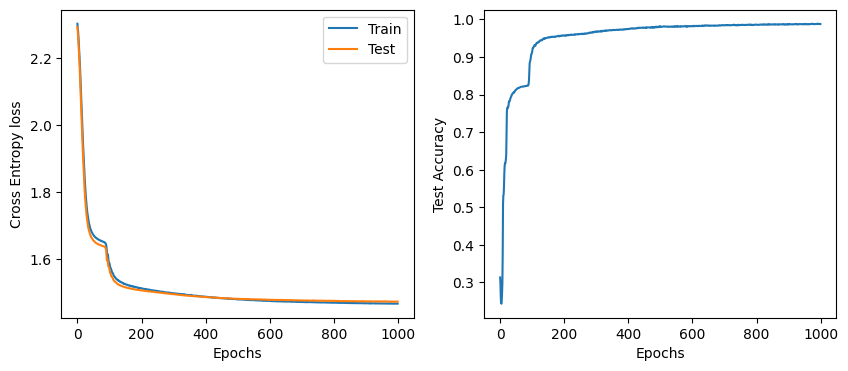

In [7]:
def plot_losses(train_losses, eval_losses, eval_acc):
    _, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(10, 4))
    loss_ax.plot(train_losses, label='Train')
    loss_ax.plot(eval_losses, label='Test')

    loss_ax.set_ylabel('Cross Entropy loss')
    loss_ax.set_xlabel('Epochs')
    loss_ax.legend()

    acc_ax.plot(eval_acc)
    acc_ax.set_ylabel('Test Accuracy')
    acc_ax.set_xlabel('Epochs')

plot_losses(train_losses, eval_losses, eval_acc)

We see that the loss converges nicely and the accuracy is almost 100%. Now let's look at its performance on the preserved data.

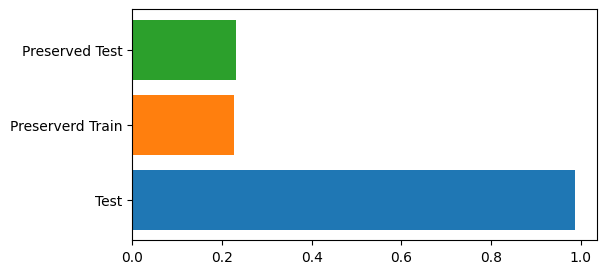

In [8]:
def eval_on_preserved(model, device):
    datasplits = [
        (X_test_1, y_test_1),
        (X_train_2, y_train_2),
        (X_test_2, y_test_2),
    ]

    model.eval()
    accuracy = []
    for x, y in datasplits:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        acc = (pred.argmax(-1) == y).sum() / len(pred)
        accuracy.append(acc.item())

    _, ax = plt.subplots(1, 1, figsize=(6, 3))
    ax.barh([0, 1, 2], accuracy, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax.set_yticks([0, 1, 2], labels=['Test', 'Preserverd Train', 'Preserved Test'])
    plt.show()

eval_on_preserved(model, 'cuda:0')

We can see that it can handle seen classes very well (20% of them, so 0.2 accuracy), but cannot generalize to the unseen classes. Now we first try to fully finetune the model.

In [9]:
device = 'cuda:0'
epochs = 100
full_model = get_clean_model()
full_model.load_state_dict(model.state_dict().copy())
full_model = full_model.to(device)
X_train = X_train_2.to(device)
y_train = y_train_2.to(device)
X_test = X_test_2.to(device)
y_test = y_test_2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(full_model.parameters())

train_losses, eval_losses, eval_acc = [], [], []

for epoch in tqdm(range(epochs), desc='Full training'):
    full_model.train()
    optimizer.zero_grad()
    pred = full_model(X_train)
    loss = criterion(pred, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    full_model.eval()
    pred = full_model(X_test)
    loss = criterion(pred, y_test)
    eval_losses.append(loss.item())
    acc = (pred.argmax(-1) == y_test).sum() / len(pred)
    eval_acc.append(acc.item())


Full training: 100%|██████████| 100/100 [00:00<00:00, 340.70it/s]


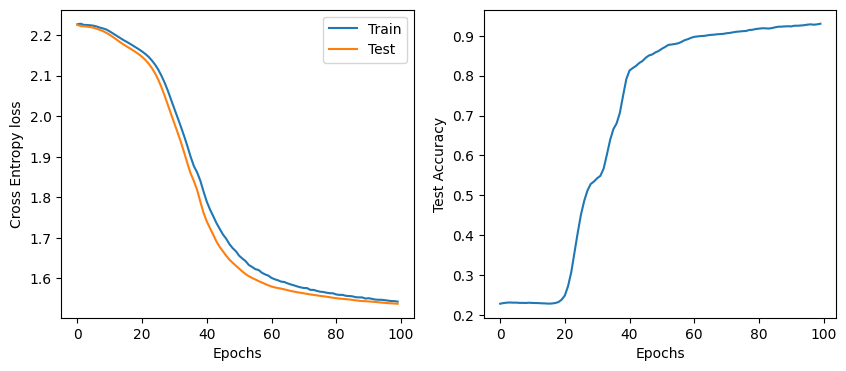

In [10]:
plot_losses(train_losses, eval_losses, eval_acc)

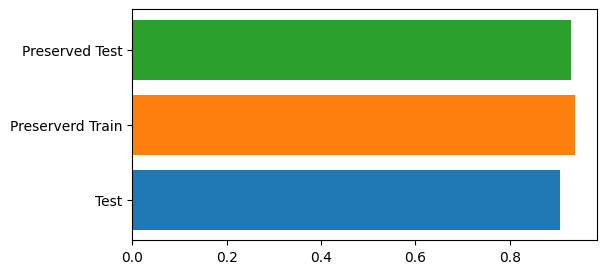

In [11]:
eval_on_preserved(full_model, 'cuda:0')

Now we see that the fully finetuned model is able to do well on the preserved dataset. However, the performance on the original dataset (`Test`) displays a slightly decrease. Now we use a LoRA style finetuning.

In [12]:
from copy import deepcopy


def replace_module(model, module_name, new_module):
    names = module_name.split('.')
    parent_module = model
    for name in names[:-1]:
        try:
            name = int(name)
            parent_module = parent_module[name]
        except ValueError:
            parent_module = getattr(parent_module, name)
    try:
        name = int(names[-1])
        old_module = parent_module[name]
        parent_module[name] = new_module
    except ValueError:
        old_module = getattr(parent_module, names[-1])
        setattr(parent_module, names[-1], new_module)
    return old_module


class LoRAModel(nn.Module):
    def __init__(self, model, layers_to_train=None, lora_dim: int = 4):
        nn.Module.__init__(self)
        self.model = deepcopy(model)
        # Freeze the parameters
        for param in self.model.parameters():
            param.requires_grad = False
        layer_map = {}
        for name, module in self.model.named_modules():
            if layers_to_train is not None:
                if name not in layers_to_train:
                    continue
            if isinstance(module, nn.Linear):
                layer_map[name] = module
        for name, module in layer_map.items():
            replace_module(self.model, name, LoRALayer(module, lora_dim))

    def forward(self, *args, **kwargs):
        return self.model(*args, **kwargs)

    def apply(self) -> nn.Module:
        model = deepcopy(self.model)
        for name, module in model.named_modules():
            if isinstance(module, LoRALayer):
                replace_module(model, name, module.apply())
        for param in model.parameters():
            param.requires_grad = True
        return model

    def trainable_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def total_parameters(self):
        return sum(p.numel() for p in self.parameters())


class LoRALayer(nn.Module):
    def __init__(self, layer: nn.Linear, r: int, alpha: int = 1):
        nn.Module.__init__(self)
        assert layer.bias is None, layer
        self.fixed = layer
        in_channels, out_channels = layer.in_features, layer.out_features
        self.A = nn.Linear(in_channels, r, bias=False)
        self.B = nn.Linear(r, out_channels, bias=False)

        self.init_params()

        self.r = r
        self.alpha = alpha
        self.scaling = self.alpha / self.r

    def init_params(self):
        nn.init.kaiming_uniform_(self.A.weight, 5 ** 0.5)
        nn.init.zeros_(self.B.weight)

    def forward(self, x):
        x_fixed = self.fixed(x)
        x_lora = self.B(self.A(x)) * self.scaling
        return x_fixed + x_lora

    @torch.no_grad()
    def apply(self) -> nn.Linear:
        layer = deepcopy(self.fixed)
        layer.weight = nn.Parameter(
            self.fixed.weight + self.B.weight @ self.A.weight * self.scaling)
        layer.requires_grad = True
        return layer


Now we can finetune a LoRA model.

In [13]:
device = 'cuda:0'
epochs = 1000
lora_model = LoRAModel(model)
lora_model = lora_model.to(device)
X_train = X_train_2.to(device)
y_train = y_train_2.to(device)
X_test = X_test_2.to(device)
y_test = y_test_2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(lora_model.parameters())

train_losses, eval_losses, eval_acc = [], [], []

for epoch in tqdm(range(epochs), desc='LoRA finetuning'):
    lora_model.train()
    optimizer.zero_grad()
    pred = lora_model(X_train)
    loss = criterion(pred, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    lora_model.eval()
    pred = lora_model(X_test)
    loss = criterion(pred, y_test)
    eval_losses.append(loss.item())
    acc = (pred.argmax(-1) == y_test).sum() / len(pred)
    eval_acc.append(acc.item())


LoRA finetuning: 100%|██████████| 1000/1000 [00:03<00:00, 250.77it/s]


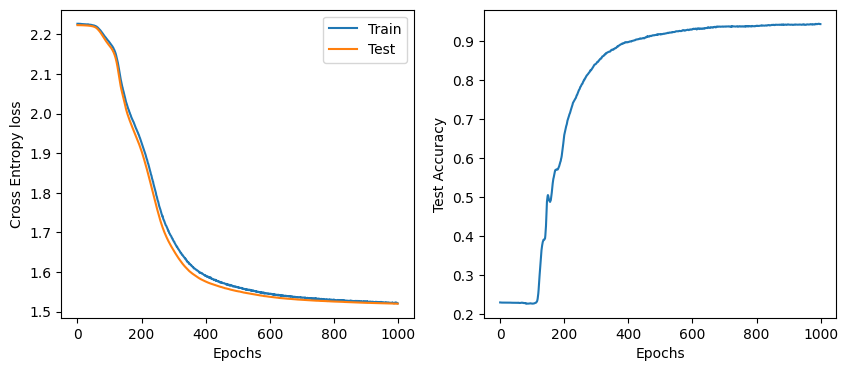

In [14]:
plot_losses(train_losses, eval_losses, eval_acc)

We can see that compared to the fully finetuning, the LoRA method requires a longer training epochs to get a high accuracy (> 0.9).

In [15]:
lora_model

LoRAModel(
  (model): MultilayerPerceptronClassifier(
    (layers): ModuleList(
      (0): Sequential(
        (0): LoRALayer(
          (fixed): Linear(in_features=784, out_features=128, bias=False)
          (A): Linear(in_features=784, out_features=4, bias=False)
          (B): Linear(in_features=4, out_features=128, bias=False)
        )
        (1): ReLU()
        (2): Dropout(p=0.05, inplace=False)
      )
      (1): Sequential(
        (0): LoRALayer(
          (fixed): Linear(in_features=128, out_features=128, bias=False)
          (A): Linear(in_features=128, out_features=4, bias=False)
          (B): Linear(in_features=4, out_features=128, bias=False)
        )
        (1): ReLU()
        (2): Dropout(p=0.05, inplace=False)
      )
    )
    (fc): LoRALayer(
      (fixed): Linear(in_features=128, out_features=10, bias=False)
      (A): Linear(in_features=128, out_features=4, bias=False)
      (B): Linear(in_features=4, out_features=10, bias=False)
    )
  )
)

Let's check the number of trainable parameters.

In [16]:
trainable = lora_model.trainable_parameters()
total = lora_model.total_parameters()
print(trainable, total, trainable / total)

5224 123240 0.042388834793898086


The trainable parameters is only 5%, that is a lot of memory saving considering the gradients and optimizer states.

In [17]:
plain_model = lora_model.apply()

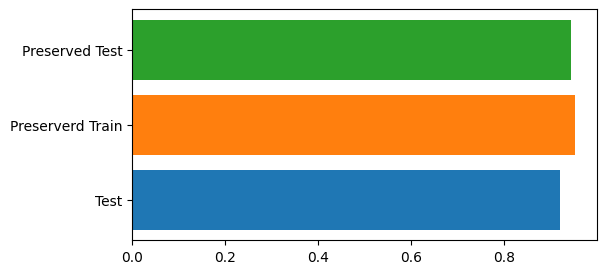

In [18]:
eval_on_preserved(lora_model, device)

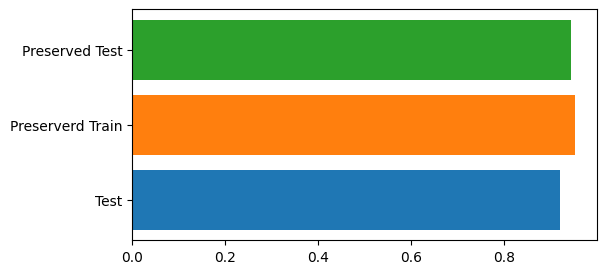

In [19]:
eval_on_preserved(plain_model, device)

Now after we converted back the model, the accuracy is still the same.